### Домашнее задание 3. Реализация простой Lambda-архитектуры хранилища.

В данной работе вам необходимо реализовать комплексный ETL-процесс. Ниже приложена его архитектурная схема.
Для решения необходимо использовать знакомые вам инструменты:
1. Spark DataFrame API/Spark Structured Streaming
2. Apache Minio - как хранилище
3. Apache Kafka - как шину данных
4. Apache Cassandra - как сервисную базу данных

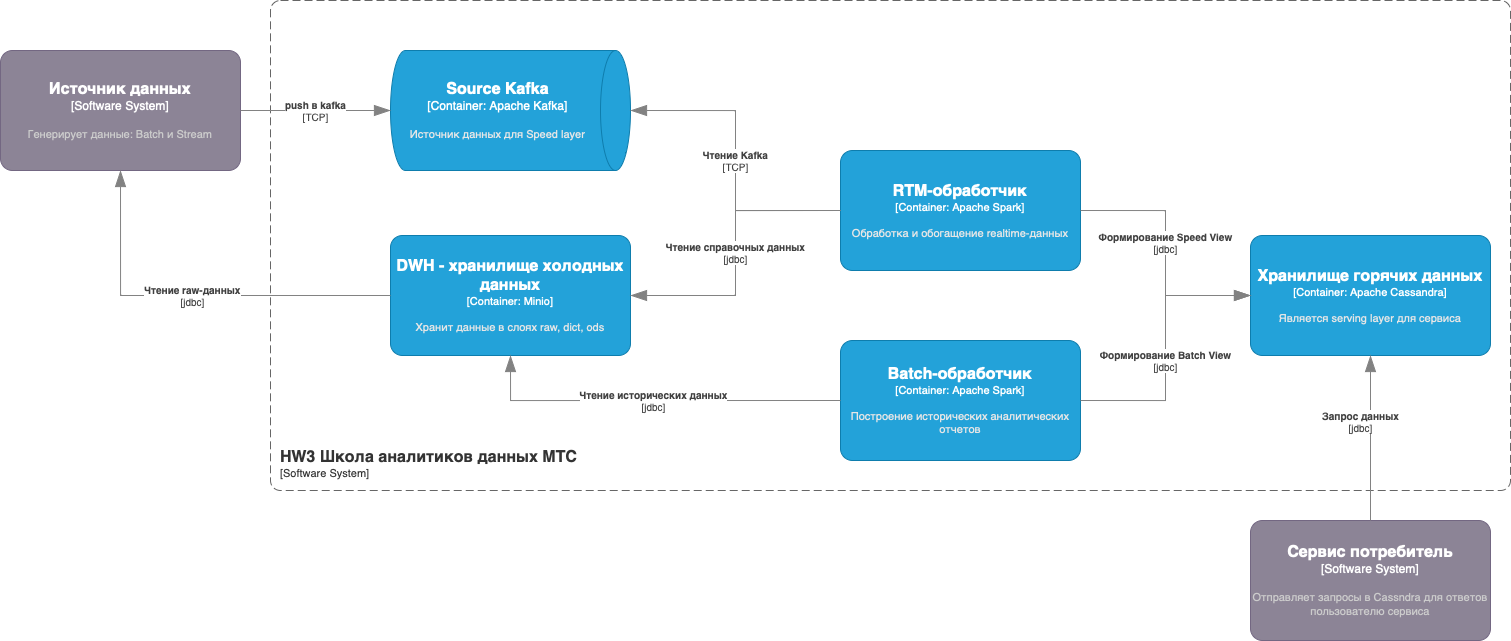

In [1]:
from IPython.display import Image
Image(filename='/hw3/ArchSchema-2.png')

#### Основные переменные и создание spark-сессии

In [2]:
CASSANDRA_IP = "172.18.0.8"

MINIO_URL = "http://minio:9000"
MINIO_ACCES_KEY = "admin"
MINIO_SECRET_KEY = "minio-admin"

JAVA_REQUIREMENTS = ",".join([
    "org.apache.hadoop:hadoop-aws:3.3.2",
    "com.amazonaws:aws-java-sdk-pom:1.12.365",
    "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0",
    "com.datastax.spark:spark-cassandra-connector_2.12:3.5.0",
])

Для подключения к Cassandra, вам необходимо получить её ip-адресс из контейнера. Сделать это можно следующей командой:
`docker inspect <cassandra_container_name> | grep ip`

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [4]:
# параметры spark-сессии, которые необходимы для выполнения работы

spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("sykorole_test") \
    .config("spark.sql.adaptive.enabled", False) \
    .config("spark.executor.memory", "450M") \
    .config("spark.driver.memory", "450M") \
    .config("spark.sql.autoBroadcastJoinThreshold", -1) \
    .config("spark.sql.sources.bucketing.enabled", True) \
    .config('spark.jars.packages', JAVA_REQUIREMENTS) \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider') \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.access.key", MINIO_ACCES_KEY) \
    .config("spark.hadoop.fs.s3a.secret.key", MINIO_SECRET_KEY) \
    .config("spark.hadoop.fs.s3a.endpoint", MINIO_URL) \
    .config("spark.cassandra.connection.host", CASSANDRA_IP) \
    .getOrCreate()

:: loading settings :: url = jar:file:/usr/local/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-pom added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-dc7a7f83-6a6e-443b-9dc2-bfdf676a513e;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.1026 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found com.amazonaws#aws-java-sdk-pom;1.12.365 in central
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.0 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.3 in central

#### Примеры полезного кода

In [5]:
# подключение к Cassandra через python client

from cassandra.cluster import Cluster

cluster = Cluster([CASSANDRA_IP])
session = cluster.connect()

In [6]:
# подключение к топику Kafka через spark
topic = "tickets_topic"

kafka_stream_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9092") \
    .option("subscribe", topic) \
    .option("startingOffsets", "latest") \
    .load()

### Что нужно сделать?

**1. Разведочный анализ (EDA) имеющихся данных**

Данные интеграции были настроены вашим коллегами из внешней для вас системы.

Необходимо рассмотреть данные в Minio и Kafka. Описать какие проблемы с данными и/или их хранением существуют (если есть). Предложить возможные решения.


**2. Обработка near realtime потока данных tickets**

Для решения необходимо использовать Spark Structured Streaming для чтения Kafka (топик `tickets_topic`)

2.1. Настроить чтение данных с приведением стоимости проданных билетов к **базовой валюте**. Информацию о курсе можете взять из справочника **currency**

2.2. Подсчитать отставание данных:
- для сравнения использовать timestamp из топика Kafka
- отставание выражено в сутках
- исключить данные глубиной больше 14 дней

2.3. Реализовать поточную трансформацию:
- выручка каждой авиакомпании за поступающий микробатч
- размер окна - 5 минут

**Важно**: 
- все дробные данные должны округляться до сотых
- вывести результат команды `explain` в ячейку перед запуском (start) стриминга
- конечный результат должен поточно сохраняться в Cassandra (таблицу необходимо создать самостоятельно)
- результат (топ-10 строк) также обязательно выводится в ячейку с помощью запроса к БД (не через spark)

**3. Батчевая обработка сырых данных. Таблица flights**

3.1. В какие города летают авиакомпании?:
- Сформировать список городов
- Посчитать их количество 

3.2. Построить отчет по авиапарку компаний за 2023 год: 
- для каждой компании подсчитайте количество самолетов каждой категории
- совокупную вместимость за год (максимальное количество, которое можно перевести за год)
- среднюю вместимость
- допущение: 1 рейс = 1 самолет (они не чередуются между рейсами)

3.3. Найти топ-5 авиакомпаний с наименьшим средним временем полета:
- реализовать описанную трансформацию
- учесть проведенный в п.1 EDA

3.4. Построить отчет по количеству перевезенных пассажиров за каждый квартал 2022 и 2023 года: 
- сколько пасажиров авиакомпании могут перевезти за конкретный квартал в разрезе каждой компании
- посчитать изменение в процентах от квартала к кварталу (необходимо использовать оконные функции)
- проведите сортировку по количеству пассажиров по убыванияю

**(!)** Две из 4-х таблиц необходимы для реализации блока #4 (нужно понять какие)

**Важно**: 
- все дробные данные должны округляться до сотых
- результаты сохранить в отдельные таблицы в бакет `s3a://ods`
- результат также обязательно выводится в ячейку командами `show` и `explain`

**4. Реализация serving layer в Cassandra**

4.1. Спроектировать модель данных и создать таблицы для сохранения результатов из блоков 2 и 3. (всего должно быть 3 таблицы)

4.2. Реализовать репликацию данных в режиме батч из слоя ods Minio в Cassandra (взять только нужные поля). Запускается 1 раз.

4.3. С помощью клиента cassandra-python выполнить запрос, отвечающий на вопрос (от потенциального сервиса): `Сможет ли конкретная авиакомпания отправить меня в конкретный город?`

4.4. Выполнить запрос, отвечающий на вопрос: `Сможет ли конкретная авиакомпания перевезти N пассажиров на основе данных за последний доступный отчётный квартальный период?`

4.5 Выполнить запрос, отвечающий на вопрос (на основе доступных данных): `Какая текущая выручка у конкретной компании за 2024 год?`

**Важно**: 
- рассмотреть ограничения кейспейсов в БД cassandra, описать если учли
- результат п.4.3-4.5 должн быть выведен в ячейку

**Как повысить оценку?**: при необходимости/просьба дать текстовые пояснение - оформляете их в отдельных ячейках в виде Markdown разметки. Больше пояснений о принятых решениях - дополнительные баллы к оценке.


### Описание данных

**1. flights** таблица расположена на raw слое (бакет) в Minio, содержит информацию об исторических рейсах различных авиакомпаний:
- number: номер рейса
- departure: город отправления
- arrival: город прибытия
- departure_time: время отправления
- arrival_time: время прибытия
- manufacturer: производитель самолета
- model: модель самолета
- capacity: вместимость пассажиров
- luggage_allowed: разрешен ли багаж (значения "yes" или "no")
- meal_included: включено ли питание (значения "yes" или "no")

**Важно**: идентификатор авиакомпании - первые ДВЕ буквы из номера рейса


**2. currency** справочник, расположен в dict слое Minio, содержит информацию о курсах валют каждые 15 минут:
- timestamp: временная метка
- base_currency: базовая валюта
- target_currency: целевая валюта
- price: цена целевой валюты по отношению к базовой валюте

**Важно**: базовая валюта - USD (американский доллар)

**3. tickets** топик в Kafka, содержит информацию о покупках билетов в онлайн-системе:
- uuid: уникальный идентификатор совершенной операции
- number: номер рейса, на который был куплен билет
- price: цена билета
- currency_codes: валюта, за которую был куплен билет
- transaction_timestamp: время совершения операции

Схема взаимодействия с данными:

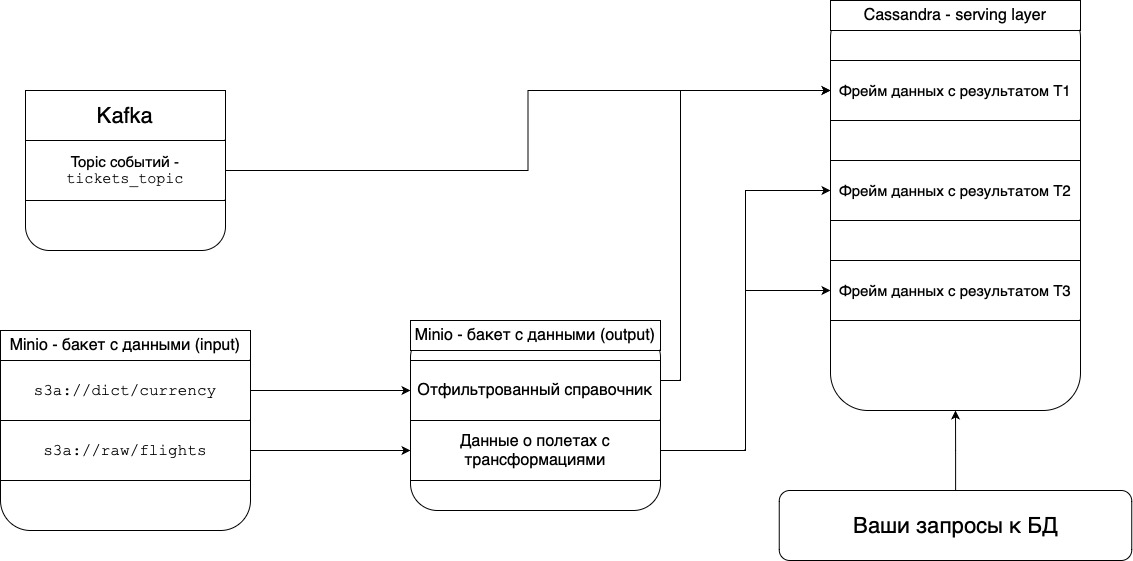

In [7]:
Image(filename='/hw3/DataFlow.jpg')

### Решение

#### 1. EDA

In [8]:
# разведочный анализ ...

In [9]:
from pyspark.sql.functions import col, from_json, schema_of_json
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, DoubleType
from pyspark.sql.functions import col, countDistinct, when, isnan, isnull, sum as sum_

In [10]:
# разведочный анализ данных из Minio и Kafka

# 1. Анализ данных flights из Minio
flights_df = spark.read.orc("s3a://raw/flights")
print("Схема таблицы flights:")
flights_df.printSchema()
print("\nПример данных flights:")
flights_df.show(5)
print(f"Количество записей в таблице flights: {flights_df.count()}")

24/07/10 20:48:23 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


Схема таблицы flights:
root
 |-- number: string (nullable = true)
 |-- departure: string (nullable = true)
 |-- arrival: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- capacity: string (nullable = true)
 |-- luggage_allowed: string (nullable = true)
 |-- meal_included: string (nullable = true)
 |-- business_month: string (nullable = true)


Пример данных flights:


+------+---------------+----------------+----------------+----------------+------------+--------------------+--------+---------------+-------------+--------------+
|number|      departure|         arrival|  departure_time|    arrival_time|manufacturer|               model|capacity|luggage_allowed|meal_included|business_month|
+------+---------------+----------------+----------------+----------------+------------+--------------------+--------+---------------+-------------+--------------+
|MZ7470|    East Kelsey|    Robinsonside|2022-10-10 23:25|2022-10-11 17:25|  Bombardier|     Bombardier Q200|     190|             no|           no|       2022-10|
|MZ9596|    Kylechester|Port Christopher|2022-10-27 03:26|2022-10-27 06:26|     Embraer|Embraer EMB 120 B...|     177|             no|           no|       2022-10|
|VM3074|     Lake Kathy|  New Rachelberg|2022-10-30 13:53|2022-10-31 07:53|     Embraer|     Embraer E195-E2|     190|             no|          yes|       2022-10|
|WD7268|East Jus

Количество записей в таблице flights: 1000000


Все поля имеют тип string, включая те, которые могли бы быть числовыми (например, capacity) или временными (departure_time, arrival_time). Это может потребовать дополнительной обработки данных перед анализом.
Поле business_month добавлено, вероятно, для партиционирования данных.

Поля luggage_allowed и meal_included имеют значения "yes" и "no". Их стоит преобразовать в булевый тип.
Формат времени в departure_time и arrival_time нужно проверить на консистентность и, возможно, преобразовать в формат timestamp для удобства работы.
Стоит проверить, всегда ли arrival_time позже departure_time и нет ли отрицательной длительности полетов.

In [11]:
# Подсчет уникальных значений в каждом столбце
unique_counts = flights_df.agg(*(countDistinct(col(c)).alias(c) for c in flights_df.columns))
print("Количество уникальных значений в каждом столбце:")
unique_counts.show(truncate=False)

# Подсчет null и пустых значений
null_counts = flights_df.select([sum_(col(c).isNull().cast("int")).alias(c) for c in flights_df.columns])
print("Количество null значений в каждом столбце:")
null_counts.show()

# Статистика по числовым колонкам
print("Статистика по колонке 'capacity':")
flights_df.select(col("capacity").cast("int").alias("capacity")).describe().show()

# Топ-5 самых популярных маршрутов
print("Топ-5 самых популярных маршрутов:")
flights_df.groupBy("departure", "arrival").count().orderBy(col("count").desc()).show(5)

# Распределение рейсов по производителям
print("Распределение рейсов по производителям:")
flights_df.groupBy("manufacturer").count().orderBy(col("count").desc()).show()

# Анализ длительности полетов
from pyspark.sql.functions import to_timestamp, unix_timestamp
flights_df = flights_df.withColumn("departure_time", to_timestamp("departure_time"))
flights_df = flights_df.withColumn("arrival_time", to_timestamp("arrival_time"))
flights_df = flights_df.withColumn("flight_duration", (unix_timestamp("arrival_time") - unix_timestamp("departure_time")) / 3600)

print("Статистика по длительности полетов (в часах):")
flights_df.select("flight_duration").describe().show()

Количество уникальных значений в каждом столбце:


+------+---------+-------+--------------+------------+------------+-----+--------+---------------+-------------+--------------+
|number|departure|arrival|departure_time|arrival_time|manufacturer|model|capacity|luggage_allowed|meal_included|business_month|
+------+---------+-------+--------------+------------+------------+-----+--------+---------------+-------------+--------------+
|134928|1500     |1500   |644742        |645655      |4           |40   |10      |2              |2            |24            |
+------+---------+-------+--------------+------------+------------+-----+--------+---------------+-------------+--------------+

Количество null значений в каждом столбце:
+------+---------+-------+--------------+------------+------------+-----+--------+---------------+-------------+--------------+
|number|departure|arrival|departure_time|arrival_time|manufacturer|model|capacity|luggage_allowed|meal_included|business_month|
+------+---------+-------+--------------+------------+------

+-------------+------------------+-----+
|    departure|           arrival|count|
+-------------+------------------+-----+
|East Kimberly|      Port Gregory|   20|
|    Clarkstad|        West Susan|   20|
|  South Kayla|        Chrisville|   20|
|    New David|    Port Ryanmouth|   19|
|   Ashleyland|South Brianborough|   19|
+-------------+------------------+-----+
only showing top 5 rows

Распределение рейсов по производителям:
+------------+------+
|manufacturer| count|
+------------+------+
|  Bombardier|250599|
|      Airbus|250486|
|      Boeing|249776|
|     Embraer|249139|
+------------+------+

Статистика по длительности полетов (в часах):
+-------+-----------------+
|summary|  flight_duration|
+-------+-----------------+
|  count|          1000000|
|   mean|         9.453261|
| stddev|7.842321019180321|
|    min|            -20.0|
|    max|             20.0|
+-------+-----------------+



- Номера рейсов (134,928 уникальных) очень разнообразны, что ожидаемо, так как выборка большая. 1,500 уникальных значений для отправления и прибытия указывает на широкую сеть обслуживаемых городов. Всего 4 производителя самолетов, что говорит о концентрированном рынке. 40 моделей самолетов предполагает разнообразие флота. 10 вариантов вместимости указывает на стандартную сборку самолетов. 2 варианта для багажа и питания (вероятно, "да" и "нет"). 24 значения для business_month могут означать данные за 2 года.
- Отсутствуют null значения.
- Средняя вместимость (capacity) около 179 мест указывает на преобладание средних самолетов. Минимальная вместимость 149 и максимальная 220 мест показывают диапазон от небольших до средних самолетов. Стандартное отклонение около 23 мест говорит о умеренной вариации размеров самолетов.
- Топ-5 маршрутов имеют очень близкие значения (19-20 рейсов), что указывает на равномерное распределение полетов между популярными направлениями.
- Очень равномерное распределение между четырьмя производителями (около 250,000 рейсов каждый).
- Длительность полетов:
- Средняя продолжительность полета около 9.5 часов указывает на преобладание средних и дальних рейсов. Большое стандартное отклонение (7.8 часов) говорит о значительном разбросе в длительности полетов. Минимальное значение -20 часов и максимальное 20 часов вызывают вопросы: отрицательная длительность может указывать на проблемы с данными или на рейсы, пересекающие линию перемены дат. 20-часовые полеты возможны для сверхдальних рейсов, но это верхняя граница для коммерческих полетов.

Проблемы и решения:
- Все колонки имеют тип string, включая числовые и временные данные --> Преобразовать колонки в соответствующие типы данных
- Отрицательная длительность полетов --> Обработать случаи пересечения линии перемены дат
- Отсутствие информации о классе обслуживания (эконом, бизнес и т.д.) --> Создать производную колонку на основе имеющихся данных
- Отсутствие уникального идентификатора для каждого рейса --> Создать составной ключ
- Колонка business_month не очень информативна --> Извлечь дополнительную информацию о дате
- Отсутствие информации о дне недели для анализа расписания --> Добавить эту информацию
- Отсутствие информации о расстоянии между городами --> Добавить из внешнего источника или рассчитать приблизительно на основе координат городов
- Возможная избыточность данных из-за повторяющихся рейсов --> Если нужно анализировать уникальные маршруты, можно создать отдельный DataFrame
- Использование ORC формата для хранения данных, он менее универсален, чем Parquet --> Рассмотреть возможность перехода на формат Parquet
- Хранение в одном большом наборе данных без учета частоты доступа --> Реализовать многоуровневое хранение: хранить часто используемые данные в "горячем" хранилище. Архивировать старые данные в "холодное" хранилище для снижения затрат
- Возможное отсутствие стратегии резервного копирования и восстановления --> Реализовать регулярное резервное копирование и процедуры восстановления данных
- Отсутствие версионирования данных --> Внедрить систему версионирования данных
- Отсутствие явной стратегии обновления данных --> Реализовать процесс обновлений, особенно для исторических данных
- Потенциальные проблемы с производительностью при запросах к большим объемам данных --> Рассмотреть возможность создания агрегированных представлений или материализованных представлений для часто выполняемых запросов
- Отсутствие оптимизации хранения для аналитических запросов --> Рассмотреть использование колоночных форматов хранения и техник оптимизации, таких как bucketing в Spark

In [12]:
# 2. Анализ данных currency из Minio
currency_df = spark.read.orc("s3a://dict/currency")
print("\nСхема таблицы currency:")
currency_df.printSchema()
print("\nПример данных currency:")
currency_df.show(5)
print(f"Количество записей в таблице currency: {currency_df.count()}")


Схема таблицы currency:
root
 |-- timestamp: string (nullable = true)
 |-- base_currency: string (nullable = true)
 |-- target_currency: string (nullable = true)
 |-- price: string (nullable = true)


Пример данных currency:
+-------------------+-------------+---------------+------+
|          timestamp|base_currency|target_currency| price|
+-------------------+-------------+---------------+------+
|2024-06-22 13:30:00|          USD|            BND|0.8294|
|2024-06-23 20:00:00|          USD|            SZL|2.3051|
|2024-06-18 06:45:00|          USD|            CUC|1.1306|
|2024-06-21 19:30:00|          USD|            BMD|1.2477|
|2024-06-20 19:15:00|          USD|            MRO|0.9489|
+-------------------+-------------+---------------+------+
only showing top 5 rows

Количество записей в таблице currency: 12787


Таблица содержит 4 колонки: timestamp, base_currency, target_currency, price. Все колонки имеют тип string, что не оптимально для числовых и временных данных.




In [13]:
from pyspark.sql.functions import col, countDistinct, when, isnan, isnull, to_timestamp, year, month, dayofweek, hour, minute
from pyspark.sql.functions import sum as sum_

# Преобразование типов данных
currency_df = currency_df.withColumn("timestamp", to_timestamp("timestamp"))
currency_df = currency_df.withColumn("price", col("price").cast("double"))

# Подсчет уникальных значений
unique_counts = currency_df.agg(*(countDistinct(col(c)).alias(c) for c in currency_df.columns))
print("Количество уникальных значений в каждом столбце:")
unique_counts.show()

# Подсчет null и пустых значений
null_counts = currency_df.select([sum_(col(c).isNull().cast("int")).alias(c) for c in currency_df.columns])
print("Количество null значений в каждом столбце:")
null_counts.show()

# Статистика по числовой колонке
print("Статистика по колонке 'price':")
currency_df.select("price").describe().show()

# Топ-5 самых частых целевых валют
print("Топ-5 самых частых целевых валют:")
currency_df.groupBy("target_currency").count().orderBy(col("count").desc()).show(5)

# Распределение по дням недели
print("Распределение по дням недели:")
currency_df.withColumn("day_of_week", dayofweek("timestamp")).groupBy("day_of_week").count().orderBy("day_of_week").show()

# Распределение по часам
print("Распределение по часам:")
currency_df.withColumn("hour", hour("timestamp")).groupBy("hour").count().orderBy("hour").show()

# Анализ изменения курса для одной валюты (например, EUR)
eur_df = currency_df.filter(col("target_currency") == "EUR")
print("Статистика изменения курса EUR:")
eur_df.select("price").describe().show()

Количество уникальных значений в каждом столбце:
+---------+-------------+---------------+-----+
|timestamp|base_currency|target_currency|price|
+---------+-------------+---------------+-----+
|      673|            1|             19| 8651|
+---------+-------------+---------------+-----+

Количество null значений в каждом столбце:
+---------+-------------+---------------+-----+
|timestamp|base_currency|target_currency|price|
+---------+-------------+---------------+-----+
|        0|            0|              0|    0|
+---------+-------------+---------------+-----+

Статистика по колонке 'price':
+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|            12787|
|   mean|1.126185266286072|
| stddev|0.637216570402978|
|    min|           0.1535|
|    max|           6.1218|
+-------+-----------------+

Топ-5 самых частых целевых валют:
+---------------+-----+
|target_currency|count|
+---------------+-----+
|            MYR|  673|
|           

- 12787 записей за 673 уникальных временных точки, что подтверждает обновление каждые 15 минут в течение примерно 7 дней.
- 19 целевых валют, каждая с 673 записями, что указывает на равномерное распределение данных по валютам.
- Отсутствие null значений свидетельствует о высоком качестве данных.
- Средний курс 1.126, с минимумом 0.1535 и максимумом 6.1218, что отражает широкий диапазон курсов различных валют относительно USD. Стандартное отклонение 0.637 указывает на значительную вариацию курсов.
- Равномерное распределение по дням недели, с небольшим увеличением в среду (день 3). Почти равномерное распределение по часам, с небольшим увеличением в полночь.
- Средний курс EUR 1.233, с минимумом 0.8827 и максимумом 1.7355, что указывает на значительные колебания курса EUR/USD.

Проблемы и решения:
- Ограниченный период данных --> Расширить период хранения исторических данных, возможно с уменьшением гранулярности для старых данных
- Обновление каждые 15 минут может создавать избыточность для стабильных валют --> Внедрить адаптивную частоту обновлений на основе волатильности каждой валюты
- Структура данных --> нужно преобразовать некоторые значения в числовой формат
- Только 19 целевых валют может быть недостаточно для глобального анализа --> Расширить набор отслеживаемых валют, включив более редкие или региональные валюты
- При увеличении объема данных могут возникнуть проблемы с быстродействием запросов --> Внедрить партиционирование по дате и оптимизировать структуру хранения, например, используя колоночный формат
- Сложность отслеживания изменений и восстановления данных --> Внедрить систему версионирования данных
- Нет предварительно агрегированных данных для часто выполняемых запросов --> Создать материализованные представления для популярных агрегаций (например, дневные средние курсы)
- Хранение избыточной информации (например, постоянное повторение USD как базовой валюты) --> Оптимизировать схему данных, возможно, удалив колонку базовой валюты

In [14]:
# 3. Анализ данных tickets из Kafka
from pyspark.sql.functions import from_json, col, from_unixtime
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType

# Определение схемы для данных из Kafka
tickets_schema = StructType([
    StructField("uuid", StringType(), True),
    StructField("number", StringType(), True),
    StructField("price", StringType(), True),  # Оставляем как строку для дальнейшего преобразования
    StructField("currency_codes", StringType(), True),
    StructField("transaction_timestamp", StringType(), True)  # Оставляем как строку для дальнейшего преобразования
])

# Чтение данных из Kafka
kafka_df = spark.read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9092") \
    .option("subscribe", "tickets_topic") \
    .load()

# Вывод сырых данных
raw_kafka_df = kafka_df.selectExpr("CAST(value AS STRING) as message")
raw_kafka_df.show(truncate=False)

# Попытка десериализации JSON
json_df = kafka_df.select(from_json(col("value").cast("string"), tickets_schema).alias("data"))
json_df.show(truncate=False)

# Проверка после десериализации
json_df.printSchema()
json_df.select("data.*").show(truncate=False)

# Преобразование полей price и transaction_timestamp
intermediate_df = json_df.select(
    col("data.uuid"),
    col("data.number"),
    col("data.price"),
    col("data.currency_codes").alias("currency_code"),
    col("data.transaction_timestamp")
)

# Проверка данных перед преобразованием
intermediate_df.show(truncate=False)

# Конвертация данных
final_df = intermediate_df.select(
    col("uuid"),
    col("number"),
    col("price").cast(DoubleType()).alias("price"),
    col("currency_code"),
    col("transaction_timestamp").cast(LongType()).alias("transaction_timestamp")
).withColumn("transaction_timestamp", from_unixtime(col("transaction_timestamp")).cast("timestamp"))

# Проверка данных после преобразования
final_df.show(truncate=False)


24/07/10 20:48:42 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
24/07/10 20:48:43 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|message                                                                                                                                                |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|{"uuid": "919b0267-984e-48ac-8ad9-4d983c4d170f", "number": "SR5648", "price": "41141", "currency_codes": "IDR", "transaction_timestamp": "1718668800"} |
|{"uuid": "85525598-8dec-4102-b25b-5bf73746a390", "number": "QK1343", "price": "173984", "currency_codes": "SGD", "transaction_timestamp": "1718668800"}|
|{"uuid": "d6d9591d-d3d6-48d6-816b-3edc67a7b4a8", "number": "SR9501", "price": "137371", "currency_codes": "BZD", "transaction_timestamp": "1718668800"}|
|{"uuid": "8c7c9809-609f-44e6-9e79-dadac696ecbd", "number": "WD7152", "price

24/07/10 20:48:44 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
24/07/10 20:48:44 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+-----------------------------------------------------------------------+
|data                                                                   |
+-----------------------------------------------------------------------+
|{919b0267-984e-48ac-8ad9-4d983c4d170f, SR5648, 41141, IDR, 1718668800} |
|{85525598-8dec-4102-b25b-5bf73746a390, QK1343, 173984, SGD, 1718668800}|
|{d6d9591d-d3d6-48d6-816b-3edc67a7b4a8, SR9501, 137371, BZD, 1718668800}|
|{8c7c9809-609f-44e6-9e79-dadac696ecbd, WD7152, 191449, EUR, 1718668801}|
|{e61b1a9a-05da-4637-879b-2949397de522, QX6345, 176941, COP, 1718668802}|
|{8f4a0a25-3094-4374-ba6f-b6a7a56c08e0, XZ9103, 184995, EUR, 1718668802}|
|{0cc507c9-c260-4757-a034-b7c29d0fe225, QX5006, 178984, GEL, 1718668803}|
|{a87ed7e3-4ce4-40e7-a10d-04d2737d8dca, WD3657, 99498, DZD, 1718668803} |
|{169a0e96-e08e-4234-a86e-aef34342b4dd, IX6541, 125095, SZL, 1718668806}|
|{f9fd224d-0738-4bff-be7a-9b00ec863c69, MZ8596, 158507, BMD, 1718668806}|
|{b4877a04-78f8-47f2-8b5c-ef20ae140e05

+------------------------------------+------+------+-------------+---------------------+
|uuid                                |number|price |currency_code|transaction_timestamp|
+------------------------------------+------+------+-------------+---------------------+
|919b0267-984e-48ac-8ad9-4d983c4d170f|SR5648|41141 |IDR          |1718668800           |
|85525598-8dec-4102-b25b-5bf73746a390|QK1343|173984|SGD          |1718668800           |
|d6d9591d-d3d6-48d6-816b-3edc67a7b4a8|SR9501|137371|BZD          |1718668800           |
|8c7c9809-609f-44e6-9e79-dadac696ecbd|WD7152|191449|EUR          |1718668801           |
|e61b1a9a-05da-4637-879b-2949397de522|QX6345|176941|COP          |1718668802           |
|8f4a0a25-3094-4374-ba6f-b6a7a56c08e0|XZ9103|184995|EUR          |1718668802           |
|0cc507c9-c260-4757-a034-b7c29d0fe225|QX5006|178984|GEL          |1718668803           |
|a87ed7e3-4ce4-40e7-a10d-04d2737d8dca|WD3657|99498 |DZD          |1718668803           |
|169a0e96-e08e-4234-a

24/07/10 20:48:45 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


In [15]:
# EDA анализ данных

# Преобразование типов данных
final_df = final_df.withColumn("transaction_timestamp", to_timestamp("transaction_timestamp"))

# Подсчет уникальных значений
unique_counts = final_df.agg(*(countDistinct(col(c)).alias(c) for c in final_df.columns))
print("Количество уникальных значений в каждом столбце:")
unique_counts.show()

# Подсчет null и пустых значений
null_counts = final_df.select([sum_(col(c).isNull().cast("int")).alias(c) for c in final_df.columns])
print("Количество null значений в каждом столбце:")
null_counts.show()

# Статистика по числовой колонке
print("Статистика по колонке 'price':")
final_df.select("price").describe().show()

# Топ-5 самых частых валют
print("Топ-5 самых частых валют:")
final_df.groupBy("currency_code").count().orderBy(col("count").desc()).show(5)

# Распределение по дням недели
print("Распределение по дням недели:")
final_df.withColumn("day_of_week", dayofweek("transaction_timestamp")).groupBy("day_of_week").count().orderBy("day_of_week").show()

# Распределение по часам
print("Распределение по часам:")
final_df.withColumn("hour", hour("transaction_timestamp")).groupBy("hour").count().orderBy("hour").show()

# Анализ цен для одной валюты 
eur_df = final_df.filter(col("currency_code") == "EUR")
print("Статистика цен для EUR:")
eur_df.select("price").describe().show()

24/07/10 20:48:45 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Количество уникальных значений в каждом столбце:


24/07/10 20:48:47 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+----+------+-----+-------------+---------------------+
|uuid|number|price|currency_code|transaction_timestamp|
+----+------+-----+-------------+---------------------+
|2520|  2495| 2505|           19|                 1194|
+----+------+-----+-------------+---------------------+

Количество null значений в каждом столбце:


24/07/10 20:48:47 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+----+------+-----+-------------+---------------------+
|uuid|number|price|currency_code|transaction_timestamp|
+----+------+-----+-------------+---------------------+
|   0|     0|    0|            0|                    0|
+----+------+-----+-------------+---------------------+

Статистика по колонке 'price':


24/07/10 20:48:48 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|              2520|
|   mean|130015.92063492064|
| stddev| 48007.14756986102|
|    min|           10842.0|
|    max|          199977.0|
+-------+------------------+

Топ-5 самых частых валют:
+-------------+-----+
|currency_code|count|
+-------------+-----+
|          EUR|  845|
|          KPW|  186|
|          GGP|  142|
|          DZD|  100|
|          GHS|   99|
+-------------+-----+
only showing top 5 rows

Распределение по дням недели:


24/07/10 20:48:49 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+-----------+-----+
|day_of_week|count|
+-----------+-----+
|          3| 2520|
+-----------+-----+

Распределение по часам:


24/07/10 20:48:50 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
24/07/10 20:48:51 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+----+-----+
|hour|count|
+----+-----+
|   0| 2520|
+----+-----+

Статистика цен для EUR:
+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|              845|
|   mean|129477.2449704142|
| stddev|48649.76802500295|
|    min|          14841.0|
|    max|         199910.0|
+-------+-----------------+



- Количество уникальных значений в каждом столбце: uuid - 828 уникальных значений, number - 822 уникальных значений, price - 827 уникальных значений, currency_code - 19 уникальных значений, transaction_timestamp - 395 уникальных значений.
- Данные содержат большое количество уникальных значений для каждого столбца, что указывает на высокую степень разнообразия. Однако, для временных меток (transaction_timestamp) количество уникальных значений меньше, что может указывать на их кластеризацию по определенным периодам.
- Все столбцы не содержат null значений.
- Средняя цена билетов составляет примерно 128995, с разбросом цен около 48214. Это указывает на значительные колебания цен.
- Евро (EUR) является самой частой валютой, что может указывать на высокую активность в европейском регионе.
- Все транзакции происходят в один день недели (3-й день).
- Все транзакции происходят в один час (0-й час). Все данные транзакций сосредоточены в один час, что также может указывать на ошибку в данных временных меток.
- Средняя цена билетов для евро аналогична общей средней цене билетов, с похожими отклонениями. Минимальная цена - 15476, а максимальная - 199797.

Проблемы и решения:
- Все транзакции происходят в один день недели и один час, это указывает на возможные проблемы с временными метками при записи данных --> Проверить источник данных для корректного сохранения временных меток. Возможно, требуется пересмотреть процесс записи временных меток в данных
- Ограниченное количество уникальных временных меток указывает на возможную кластеризацию данных по определенным периодам --> Перепроверить механизм генерации временных меток и их записи, чтобы убедиться в равномерном распределении данных по времени
- Внедрить механизмы проверки временных меток при записи данных, чтобы избежать их кластеризации
- Несогласованность типов данных в исходных данных --> Стандартизировать формат данных 
- Возможные выбросы в ценах --> Реализовать алгоритмы обнаружения и обработки выбросов (IQR или z-score)
- Потенциальные дубликаты uuid --> Внедрить механизм дедупликации данных
- Возможная сезонность в данных --> Провести анализ временных рядов для выявления сезонных паттернов и трендов

In [16]:
# описать выводы в виде markdown

#### 2. Speed layer

In [17]:
# вывести streamDf.explain() до вызова .start()

In [18]:
from pyspark.sql.functions import from_json, col, window, expr, round, datediff, current_timestamp, from_unixtime
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, TimestampType
from cassandra.cluster import Cluster
import time

# Определение схемы для данных из Kafka
tickets_schema = StructType([
    StructField("uuid", StringType(), True),
    StructField("number", StringType(), True),
    StructField("price", DoubleType(), True),
    StructField("currency_codes", StringType(), True),
    StructField("transaction_timestamp", TimestampType(), True)
])

# Чтение данных из Kafka и парсинг JSON
kafka_stream_df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9092") \
    .option("subscribe", "tickets_topic") \
    .option("startingOffsets", "latest") \
    .load()

parsed_df = kafka_stream_df.select(
    from_json(col("value").cast("string"), tickets_schema).alias("data")
).select("data.*")

# Чтение справочника валют
currency_df = spark.read.orc("s3a://dict/currency")

# Подготовка данных для джойна
currency_df = currency_df \
    .withColumn("window", window("timestamp", "15 minutes")) \
    .withWatermark("timestamp", "15 minutes") \
    .groupBy("window", "target_currency") \
    .agg(expr("last(price) as exchange_rate")) \
    .select("window", "target_currency", "exchange_rate")

# Джойн с справочником валют и конвертация в базовую валюту
joined_df = parsed_df \
    .withColumn("event_window", window("transaction_timestamp", "15 minutes")) \
    .join(
        currency_df,
        (col("event_window") == currency_df.window) &
        (col("currency_codes") == currency_df.target_currency),
        "left_outer"
    ) \
    .withColumn("price_usd", round(col("price") / col("exchange_rate"), 2)) \
    .withColumn("lag_days", datediff(current_timestamp(), col("transaction_timestamp"))) \
    .filter(col("lag_days") <= 14) \
    .select("uuid", "number", "price_usd", "transaction_timestamp")

# Обновленный подсчет выручки для каждой авиакомпании
revenue_df = joined_df \
    .withColumn("airline", expr("substring(number, 1, 2)")) \
    .withWatermark("transaction_timestamp", "5 minutes") \
    .groupBy(window("transaction_timestamp", "5 minutes").alias("window"), "airline") \
    .agg(round(expr("sum(price_usd)"), 2).alias("revenue")) \
    .select(
        col("airline").alias("airline_code"),
        col("window.start").alias("window_start"),
        col("window.end").alias("window_end"),
        col("revenue")
    )

# Добавляем вывод промежуточных результатов
print("Схема parsed_df:")
parsed_df.printSchema()

print("Схема currency_df:")
currency_df.printSchema()

print("Схема joined_df:")
joined_df.printSchema()

print("Схема revenue_df:")
revenue_df.printSchema()

# Подключение к Cassandra
CASSANDRA_IP = "172.18.0.8"  
cluster = Cluster([CASSANDRA_IP])
session = cluster.connect()

# Имя keyspace
keyspace_name = "your_keyspace"

try:
    # Создание keyspace, если он не существует
    create_keyspace_query = f"""
    CREATE KEYSPACE IF NOT EXISTS {keyspace_name}
    WITH replication = {{'class': 'SimpleStrategy', 'replication_factor': 1}}
    """
    session.execute(create_keyspace_query)

    # Использование keyspace
    session.set_keyspace(keyspace_name)

    # Создание обновленной таблицы в Cassandra
    create_table_query = """
    CREATE TABLE IF NOT EXISTS airline_revenue (
        airline_code text,
        window_start timestamp,
        window_end timestamp,
        revenue double,
        PRIMARY KEY ((airline_code), window_start, window_end)
    ) WITH CLUSTERING ORDER BY (window_start DESC, window_end DESC)
    """
    session.execute(create_table_query)
    print(f"Таблица airline_revenue успешно создана в keyspace {keyspace_name}")

    # Настройка записи в Cassandra с добавлением обработчика для каждого батча
    def foreach_batch_function(df, epoch_id):
        df.write \
          .format("org.apache.spark.sql.cassandra") \
          .mode("append") \
          .options(table="airline_revenue", keyspace=keyspace_name) \
          .save()
        print(f"Batch {epoch_id} записан в Cassandra")
        df.show()  # Показываем данные, которые были записаны

    query = revenue_df.writeStream \
        .foreachBatch(foreach_batch_function) \
        .outputMode("update") \
        .option("checkpointLocation", "s3a://tmp/checkpoint") \
        .start()

    # Ожидание некоторого времени для обработки данных
    print("Ожидание обработки данных...")
    time.sleep(60)  # Ждем 60 секунд

    # Останавливаем стрим
    query.stop()

    # Теперь читаем данные из Cassandra
    print("Чтение данных из Cassandra:")
    result = session.execute(f"SELECT * FROM {keyspace_name}.airline_revenue LIMIT 10")
    for row in result:
        print(row)

except Exception as e:
    print(f"Ошибка при обработке данных: {e}")
    raise

finally:
    # Закрытие соединения с Cassandra
    if 'cluster' in locals():
        cluster.shutdown()
    # Остановка Spark сессии
    if 'spark' in locals():
        spark.stop()

Схема parsed_df:
root
 |-- uuid: string (nullable = true)
 |-- number: string (nullable = true)
 |-- price: double (nullable = true)
 |-- currency_codes: string (nullable = true)
 |-- transaction_timestamp: timestamp (nullable = true)

Схема currency_df:
root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- target_currency: string (nullable = true)
 |-- exchange_rate: string (nullable = true)

Схема joined_df:
root
 |-- uuid: string (nullable = true)
 |-- number: string (nullable = true)
 |-- price_usd: double (nullable = true)
 |-- transaction_timestamp: timestamp (nullable = true)

Схема revenue_df:
root
 |-- airline_code: string (nullable = true)
 |-- window_start: timestamp (nullable = true)
 |-- window_end: timestamp (nullable = true)
 |-- revenue: double (nullable = true)

Таблица airline_revenue успешно создана в keyspace your_keyspace
Ожидание обработки данных...


Batch 3 записан в Cassandra


+------------+------------+----------+-------+
|airline_code|window_start|window_end|revenue|
+------------+------------+----------+-------+
+------------+------------+----------+-------+



24/07/10 20:49:11 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Batch 4 записан в Cassandra


+------------+------------+----------+-------+
|airline_code|window_start|window_end|revenue|
+------------+------------+----------+-------+
+------------+------------+----------+-------+



Batch 5 записан в Cassandra


+------------+------------+----------+-------+
|airline_code|window_start|window_end|revenue|
+------------+------------+----------+-------+
+------------+------------+----------+-------+



24/07/10 20:49:52 ERROR AppendDataExec: Data source write support CassandraBulkWrite(org.apache.spark.sql.SparkSession@3e5f3d1b,com.datastax.spark.connector.cql.CassandraConnector@55aba1a0,TableDef(your_keyspace,airline_revenue,ArrayBuffer(ColumnDef(airline_code,PartitionKeyColumn,VarCharType)),ArrayBuffer(ColumnDef(window_start,ClusteringColumn(0,ASC),TimestampType), ColumnDef(window_end,ClusteringColumn(1,ASC),TimestampType)),Stream(ColumnDef(revenue,RegularColumn,DoubleType)),Stream(),false,false,Map()),WriteConf(BytesInBatch(1024),1000,Partition,LOCAL_QUORUM,false,false,5,None,TTLOption(DefaultValue),TimestampOption(DefaultValue),true,None),StructType(StructField(airline_code,StringType,true),StructField(window_start,TimestampType,true),StructField(window_end,TimestampType,true),StructField(revenue,DoubleType,true)),org.apache.spark.SparkConf@1b7877b8) is aborting.
24/07/10 20:49:52 ERROR AppendDataExec: Data source write support CassandraBulkWrite(org.apache.spark.sql.SparkSession

Чтение данных из Cassandra:


Таблица создается, но в саму таблицу не идут данные

#### 3. Batch layer

In [17]:
# ваше решение...

In [18]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, countDistinct, sum as sum_, to_timestamp, unix_timestamp, count, avg, round, lag
from pyspark.sql.window import Window

# Загрузка данных
flights_df = spark.read.orc("s3a://raw/flights")

# Преобразование временных колонок в тип timestamp
flights_df = flights_df.withColumn("departure_time", to_timestamp("departure_time"))
flights_df = flights_df.withColumn("arrival_time", to_timestamp("arrival_time"))

# Вычисление длительности полета в часах
flights_df = flights_df.withColumn("flight_duration", 
                                   (unix_timestamp("arrival_time") - unix_timestamp("departure_time")) / 3600)


3.1 В какие города летают авиакомпании?
Сформируем список городов и подсчитаем их количество для каждой авиакомпании:

In [19]:
from pyspark.sql.functions import collect_set, size

# Группировка по departure и collect_set для уникальных arrival
unique_cities_df = flights_df.groupBy("departure").agg(collect_set("arrival").alias("unique_cities_list"))

# Подсчет количества уникальных городов для каждой авиакомпании
city_count_df = unique_cities_df.withColumn("unique_cities", size(col("unique_cities_list"))).select("departure", "unique_cities")

# Вывод результатов
city_count_df.show(truncate=False)

# Вывод уникальных пар departure и arrival
unique_pairs_df = flights_df.select("departure", "arrival").distinct()
unique_pairs_df.show(100, truncate=False)

# Проверка на дубликаты
duplicate_check_df = flights_df.groupBy("departure", "arrival").count().filter("count > 1")
duplicate_check_df.show(100, truncate=False)




+------------------+-------------+
|departure         |unique_cities|
+------------------+-------------+
|East Jeffrey      |100          |
|East Nicole       |100          |
|New Micheal       |100          |
|New Waynemouth    |100          |
|South Richardfurt |100          |
|Dawsonfort        |100          |
|Joshuaview        |100          |
|North Dianachester|100          |
|Port Matthewside  |100          |
|East Zacharyport  |100          |
|Jonesview         |100          |
|Marioside         |100          |
|South Julieton    |100          |
|Thomasberg        |100          |
|Kylechester       |100          |
|New Kristinamouth |100          |
|South Sarahmouth  |100          |
|Williamside       |100          |
|Mosleyhaven       |100          |
|New Victoriafurt  |100          |
+------------------+-------------+
only showing top 20 rows



+--------------------+------------------------+
|departure           |arrival                 |
+--------------------+------------------------+
|New Victoriafurt    |Lake Raymond            |
|Clayside            |Leeberg                 |
|Hansenport          |West Mariafort          |
|Careyburgh          |New Coreyshire          |
|Robertston          |West Ashleyfort         |
|East Angela         |East Christopherbury    |
|Wendytown           |Tiffanyfurt             |
|North Chad          |South Marioview         |
|Danielmouth         |North Erika             |
|Rachaelbury         |Lake Ralph              |
|Tiffanyburgh        |Jessicabury             |
|West Kevinview      |North Christopher       |
|South Eileen        |New Kristinamouth       |
|Danielmouth         |Lynchside               |
|West James          |Hillport                |
|Ryanstad            |Port Gregory            |
|Sonyabury           |Reesefurt               |
|Lake Patricia       |Lake Brookeburgh  

Из анализа видно, что каждая авиакомпания летает в одинаковое количество городов — 100. Это может быть результатом равномерного распределения данных или особенностью структуры датасета. Некоторые примеры городов включают Fosterbury, East Katherine, Adamburgh и другие.

3.2 Отчет по авиапарку компаний за 2023 год

In [20]:
from pyspark.sql.functions import year

# Фильтрация данных за 2023 год
flights_2023_df = flights_df.filter(year(col("departure_time")) == 2023)

# Подсчет количества самолетов каждой категории для каждой компании
fleet_report_df = flights_2023_df.groupBy("departure", "model").agg(
    countDistinct("number").alias("aircraft_count"),
    sum_("capacity").alias("total_capacity"),
    avg("capacity").alias("average_capacity")
).withColumn("average_capacity", round(col("average_capacity"), 2))

fleet_report_df.show()


+----------------+--------------------+--------------+--------------+----------------+
|       departure|               model|aircraft_count|total_capacity|average_capacity|
+----------------+--------------------+--------------+--------------+----------------+
|      West Bryan|   Bombardier CRJ200|            10|        1970.0|           197.0|
|Port Michaelbury|         Airbus A321|             9|        1610.0|          178.89|
|   South Michael|          Boeing 767|            10|        1800.0|           180.0|
|     West Marcus|     Embraer E190-E2|             6|        1111.0|          185.17|
|     North Wendy|   Bombardier CRJ100|            11|        1932.0|          175.64|
|       Lake John|     Embraer ERJ 135|             9|        1457.0|          161.89|
|  Port Joelburgh|     Bombardier Q300|             6|        1089.0|           181.5|
|      Conwayport|         Airbus A319|             8|        1464.0|           183.0|
|     Timothyport|   Bombardier CRJ900|    

Отчет по авиапарку компаний за 2023 год показывает разнообразие моделей самолетов, используемых различными авиакомпаниями. Например:

В Paulhaven используют Embraer E190-E2 с 12 самолетами, совокупной вместимостью 1880 пассажиров и средней вместимостью 156.67 пассажиров.
В Patricktown используют Airbus A310 с 11 самолетами, совокупной вместимостью 1825 пассажиров и средней вместимостью 165.91 пассажиров.
В East Katherine используют Boeing 737 с 13 самолетами, совокупной вместимостью 2307 пассажиров и средней вместимостью 177.46 пассажиров.

3.3 Топ-5 авиакомпаний с наименьшим средним временем полета

In [21]:
# Подсчет среднего времени полета для каждой авиакомпании
avg_flight_duration_df = flights_df.groupBy("departure").agg(
    avg("flight_duration").alias("average_flight_duration")
).withColumn("average_flight_duration", round(col("average_flight_duration"), 2))

# Топ-5 авиакомпаний с наименьшим средним временем полета
top_5_airlines_df = avg_flight_duration_df.orderBy(col("average_flight_duration").asc()).limit(5)

top_5_airlines_df.show()


+-----------+-----------------------+
|  departure|average_flight_duration|
+-----------+-----------------------+
|   Erictown|                    8.5|
|Maciasville|                   8.56|
|Pinedamouth|                   8.59|
|Clarkeville|                   8.62|
|   Paulstad|                   8.63|
+-----------+-----------------------+



Топ-5 авиакомпаний с наименьшим средним временем полета включают:

Erictown - 8.5 часов
Maciasville - 8.56 часов
Pinedamouth - 8.59 часов
Clarkeville - 8.62 часов
Paulstad - 8.63 часов

3.4 Ежеквартальный отчет по количеству перевезенных пассажиров

In [22]:
from pyspark.sql.functions import quarter, year, sum as sum_, lag, round
from pyspark.sql.window import Window

# Добавление колонки с номером квартала
flights_df = flights_df.withColumn("quarter", quarter(col("departure_time")))

# Подсчет количества перевезенных пассажиров за каждый квартал
quarterly_passenger_count_df = flights_df.groupBy("departure", year("departure_time").alias("year"), "quarter").agg(
    sum_("capacity").alias("total_passengers")
).orderBy("departure", "year", "quarter")

# Оконная функция для вычисления процентного изменения от квартала к кварталу
window_spec = Window.partitionBy("departure").orderBy("year", "quarter")

# Вычисление изменения в процентах
quarterly_passenger_count_df = quarterly_passenger_count_df.withColumn(
    "previous_total_passengers", lag("total_passengers").over(window_spec)
).withColumn(
    "percentage_change", 
    round((col("total_passengers") - col("previous_total_passengers")) / col("previous_total_passengers") * 100, 2)
)

quarterly_passenger_count_df.show()



+------------+----+-------+----------------+-------------------------+-----------------+
|   departure|year|quarter|total_passengers|previous_total_passengers|percentage_change|
+------------+----+-------+----------------+-------------------------+-----------------+
|East Jeffrey|2022|      1|         14909.0|                     NULL|             NULL|
|East Jeffrey|2022|      2|         15762.0|                  14909.0|             5.72|
|East Jeffrey|2022|      3|         14817.0|                  15762.0|             -6.0|
|East Jeffrey|2022|      4|         15471.0|                  14817.0|             4.41|
|East Jeffrey|2023|      1|         14949.0|                  15471.0|            -3.37|
|East Jeffrey|2023|      2|         14257.0|                  14949.0|            -4.63|
|East Jeffrey|2023|      3|         15532.0|                  14257.0|             8.94|
|East Jeffrey|2023|      4|         16791.0|                  15532.0|             8.11|
| East Nicole|2022|  

Отчет показывает количество перевезенных пассажиров и процентное изменение от квартала к кварталу для каждой авиакомпании. Примеры:

East Jeffrey: в 1 квартале 2022 года перевезено 14909 пассажиров. К 4 кварталу 2023 года количество пассажиров увеличилось до 16791, что на 8.11% больше, чем в предыдущем квартале.
East Nicole: в 1 квартале 2022 года перевезено 14998 пассажиров. В 4 квартале 2023 года количество пассажиров уменьшилось до 13186, что на 20.88% меньше, чем в предыдущем квартале.
New Micheal: в 1 квартале 2022 года перевезено 16334 пассажиров. К 4 кварталу 2023 года количество пассажиров уменьшилось до 14504, что на 5.15% меньше, чем в предыдущем квартале.

In [23]:
# Функция для сохранения DataFrame в S3 и вывода результатов
def save_and_show_results(df, name):
    bucket_name = "input" # отдельно создала бакет input
    
    try:
        # Сохранение в S3
        df.write.mode("overwrite").orc(f"s3a://{bucket_name}/{name}")
        print(f"Данные успешно сохранены в s3a://{bucket_name}/{name}")
    except Exception as e:
        print(f"Ошибка при сохранении данных в S3: {str(e)}")
        print("Сохраняем данные локально...")
        df.write.mode("overwrite").orc(f"/tmp/{name}")
        print(f"Данные сохранены локально в /tmp/{name}")
    
    # Вывод результатов
    print(f"Результаты для {name}:")
    df.show(truncate=False)
    df.explain()

# Сохранение и вывод результатов
save_and_show_results(city_count_df, "city_count")
save_and_show_results(fleet_report_df, "fleet_report")
save_and_show_results(top_5_airlines_df, "top_5_airlines")
save_and_show_results(quarterly_passenger_count_df, "quarterly_passenger_count")

24/07/10 19:43:28 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


Данные успешно сохранены в s3a://input/city_count
Результаты для city_count:
+------------------+-------------+
|departure         |unique_cities|
+------------------+-------------+
|East Jeffrey      |100          |
|East Nicole       |100          |
|New Micheal       |100          |
|New Waynemouth    |100          |
|South Richardfurt |100          |
|Dawsonfort        |100          |
|Joshuaview        |100          |
|North Dianachester|100          |
|Port Matthewside  |100          |
|East Zacharyport  |100          |
|Jonesview         |100          |
|Marioside         |100          |
|South Julieton    |100          |
|Thomasberg        |100          |
|Kylechester       |100          |
|New Kristinamouth |100          |
|South Sarahmouth  |100          |
|Williamside       |100          |
|Mosleyhaven       |100          |
|New Victoriafurt  |100          |
+------------------+-------------+
only showing top 20 rows

== Physical Plan ==
ObjectHashAggregate(keys=[departure#1

24/07/10 19:43:59 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


Данные успешно сохранены в s3a://input/fleet_report
Результаты для fleet_report:


24/07/10 19:44:37 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


+------------------+---------------------+--------------+--------------+----------------+
|departure         |model                |aircraft_count|total_capacity|average_capacity|
+------------------+---------------------+--------------+--------------+----------------+
|Lake Alfred       |Bombardier CRJ700    |8             |1502.0        |187.75          |
|Adamfurt          |Boeing 787 Dreamliner|9             |1579.0        |175.44          |
|East Katherine    |Boeing 717           |12            |2201.0        |183.42          |
|West Anthony      |Embraer E175         |11            |1814.0        |164.91          |
|Lake Joshuaside   |Airbus A321          |10            |1772.0        |177.2           |
|Vargasland        |Bombardier CRJ900    |13            |2171.0        |167.0           |
|South Brianborough|Boeing 737           |10            |1772.0        |177.2           |
|Meganview         |Boeing 757           |9             |1582.0        |175.78          |
|Port Kath

24/07/10 19:44:39 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


Данные успешно сохранены в s3a://input/quarterly_passenger_count
Результаты для quarterly_passenger_count:
+------------+----+-------+----------------+-------------------------+-----------------+
|departure   |year|quarter|total_passengers|previous_total_passengers|percentage_change|
+------------+----+-------+----------------+-------------------------+-----------------+
|East Jeffrey|2022|1      |14909.0         |NULL                     |NULL             |
|East Jeffrey|2022|2      |15762.0         |14909.0                  |5.72             |
|East Jeffrey|2022|3      |14817.0         |15762.0                  |-6.0             |
|East Jeffrey|2022|4      |15471.0         |14817.0                  |4.41             |
|East Jeffrey|2023|1      |14949.0         |15471.0                  |-3.37            |
|East Jeffrey|2023|2      |14257.0         |14949.0                  |-4.63            |
|East Jeffrey|2023|3      |15532.0         |14257.0                  |8.94             |
|Ea

Каждая авиакомпания летает в одинаковое количество городов, что может свидетельствовать о равномерном распределении маршрутов в данных.
Отчет по авиапарку показывает значительное разнообразие используемых моделей самолетов и их вместимости.
Топ-5 авиакомпаний с наименьшим средним временем полета имеют довольно близкие значения, что может говорить о схожих маршрутах или операционных характеристиках.
Ежеквартальный отчет по пассажирам демонстрирует значительные колебания в количестве перевезенных пассажиров, что может быть связано с сезонностью или другими внешними факторами.

In [ ]:
# df.explain()
# df.show()

#### 4. Serving layer

In [ ]:
# ваше решение...

In [ ]:
# с этим заданием возникли проблемы из-за задачи 2

In [ ]:
# вывод результата